# Monty Hall

In [1]:
import pandas as pd
from fractions import Fraction

table = pd.DataFrame(index=['Door 1', 'Door 2', 'Door 3'])
table['Prior'] = Fraction(1, 3)
table

,Prior
Door 1,1/3
Door 2,1/3
Door 3,1/3


In [2]:
table['Likelihood'] = Fraction(1, 2), 1, 0
table

,Prior,Likelihood
Door 1,1/3,1/2
Door 2,1/3,1
Door 3,1/3,0


In [3]:
table['Prior * Likelihood'] = table['Prior'] * table['Likelihood']
table

,Prior,Likelihood,Prior * Likelihood
Door 1,1/3,1/2,1/6
Door 2,1/3,1,1/3
Door 3,1/3,0,0


In [4]:
prob_total = table['Prior * Likelihood'].sum()
prob_total

Fraction(1, 2)

In [5]:
table['Posterior'] = table['Prior * Likelihood'] / prob_total
table

,Prior,Likelihood,Prior * Likelihood,Posterior
Door 1,1/3,1/2,1/6,1/3
Door 2,1/3,1,1/3,2/3
Door 3,1/3,0,0,0


# Estimations

In [6]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
# Setting a random seed for reproducibility
np.random.seed(23)

# True parameter values
alpha = -0.8
beta = [-1, 1.5]
sigma = 1

# Number of observations
size = 500

# Predictor variables
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.8

# Outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

# Putting our original data into a dataframe (we'll use it later on)
df = pd.DataFrame(
    data = np.array([X1, X2, Y]),
    index=['X1', 'X2', 'Y']
).T

## Regression

### Linear regression from scratch

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Avisia\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Avisia\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Avisia\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 786 seconds.


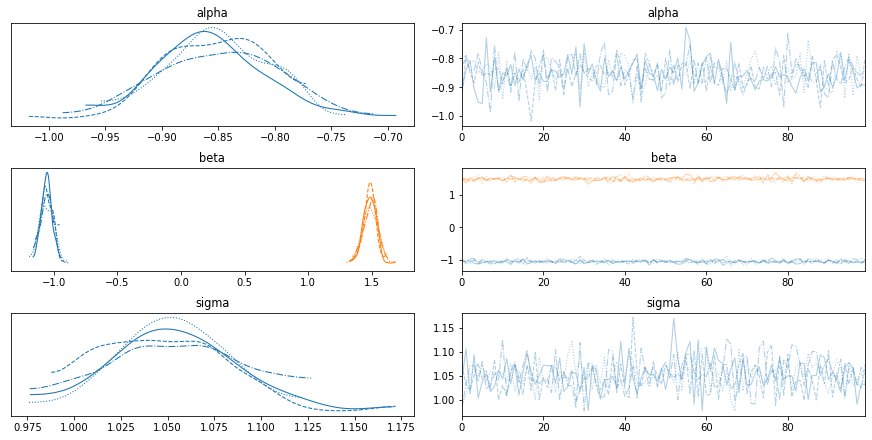

In [8]:
with pm.Model() as model_1:
    # Data
    X_1 = pm.Data('X1', X1)
    X_2 = pm.Data('X2', X2)

    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Likelihood
    mu = alpha + beta[0] * X_1 + beta[1] * X_2
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    
    # Posterior
    trace = pm.sample(100, return_inferencedata=False, chains=4)
    az.plot_trace(trace)

In [10]:
with model_1:

    pm.set_data({
        'X1': [0.6, 0.02],
        'X2': [-1.3, 0.3]
    })
    y_test = pm.fast_sample_posterior_predictive(trace, samples=100)

print(y_test['Y_obs'].mean(axis=0))

[-3.20134601 -0.48411743]


C:\Users\Avisia\anaconda3\lib\site-packages\pymc3\distributions\posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [9]:
pm.find_MAP(model=model_1)

C:\Users\Avisia\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Avisia\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Avisia\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


{'alpha': array(-0.85492716),
 'beta': array([-1.05603871,  1.48859634]),
 'sigma_log__': array(0.04380838),
 'sigma': array(1.04478214)}

### Linear regression using GLM

In [11]:
from pymc3.glm import GLM

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
<ipython-input-12-6b30c1de9811>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(100)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, X2, X1, Intercept]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 247 seconds.
<ipython-input-12-6b30c1de9811>:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


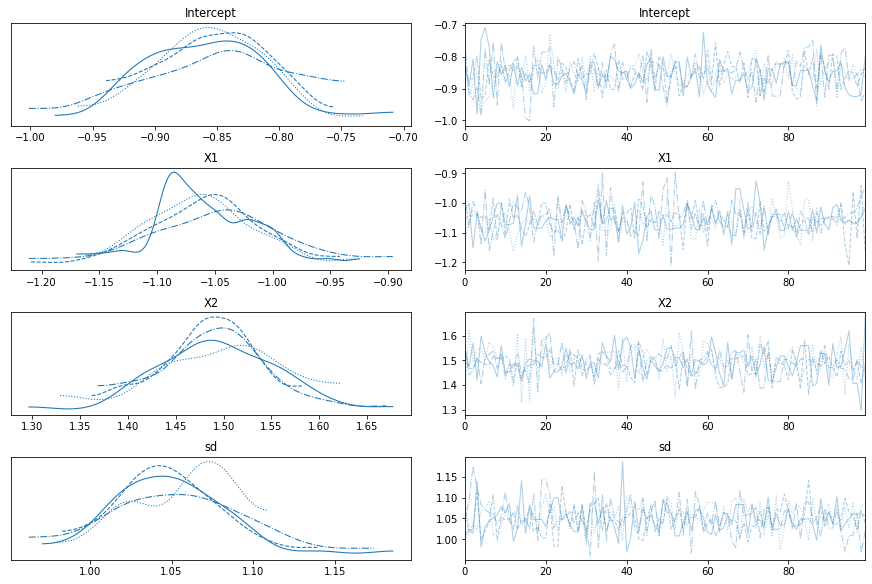

In [12]:
# Creating our model
with pm.Model() as model_glm:
    
    GLM.from_formula('Y ~ X1 + X2', df)
    trace = pm.sample(100)
    pm.traceplot(trace)
    plt.show()

## Classification

In [13]:
# Creating a binary variable
df['Y_bin']=df['Y']>df['Y'].mean()

### Logistic regression "from scratch"

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Avisia\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Avisia\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 363 seconds.
The acceptance probability does not match the target. It is 0.8795481143178954, but should be close to 0.8. Try to increase the number of tuning steps.


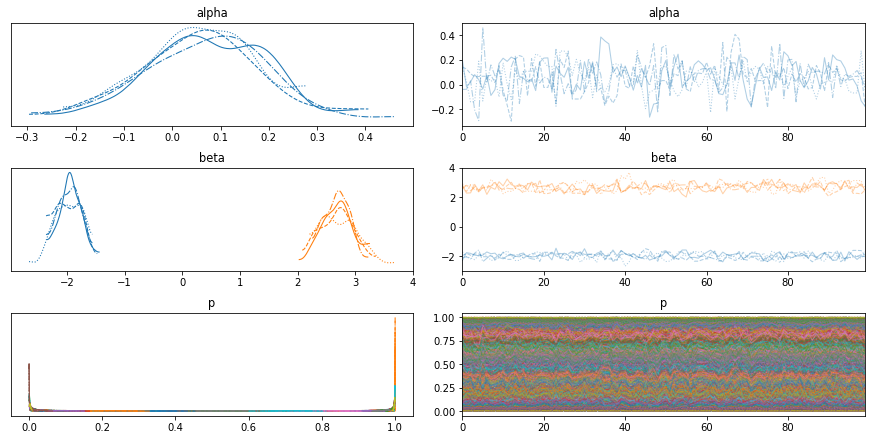

In [14]:
with pm.Model() as model_log:

    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)

    # Likelihood    
    p = pm.Deterministic('p', pm.math.sigmoid(alpha + beta[0] * X1 + beta[1] * X2))
    Y_obs = pm.Bernoulli("Y_obs", p, observed=df['Y_bin'])
    
    # Posterior
    trace = pm.sample(100, return_inferencedata=False, chains=4)
    az.plot_trace(trace)

### Logistic regression using GLM

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
<ipython-input-15-ed725ca1bea1>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(100)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Avisia\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Avisia\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [X2, X1, Intercept]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 395 seconds.
<ipython-input-15-ed725ca1bea1>:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


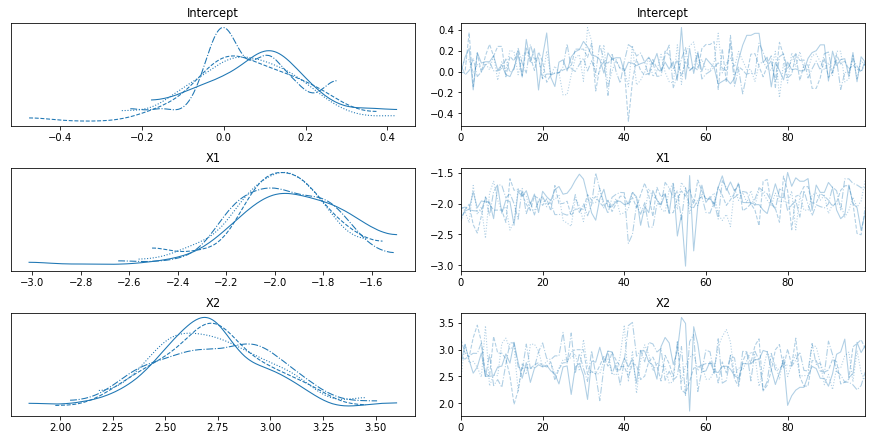

In [15]:
from pymc3.glm.families import Binomial

with pm.Model() as model_glm_logistic:
    GLM.from_formula('Y_bin ~ X1 + X2', df, family=Binomial())
    trace = pm.sample(100)
    pm.traceplot(trace)
    plt.show()